In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [183]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [184]:
data = pd.read_csv('./dataset/cleaned_merged_dataset.csv')

In [185]:
mask = (data.Nature_Code != 'Military')
data = data[mask]
mask = (data.Year > 1960)
data = data[mask]

In [186]:
data.columns

Index(['FlightNumber', 'Time', 'Day', 'Month', 'Year', 'Decade',
       'AirplaneDamage', 'AirplaneFate', 'Phase', 'Crash_Elev_m', 'Age',
       'Operator', 'Nature_Code', 'Type_Code', 'Engine_Type', 'Engine_count',
       'Crew_Fatal', 'Crew_Occ', 'Total_Fatal', 'Total_Occ', 'Psngr_Fatal',
       'Psngr_Occ', 'GndFatal', 'Coll_Fatal', 'Country', 'Continents',
       'Hemisphere', 'Seasons', 'orig_latitude', 'orig_longitude', 'label'],
      dtype='object')

In [187]:
data_aus = data[data['Continents'] == 'Asia']

In [188]:
data_aus.shape

(871, 31)

In [189]:
data_aus = data_aus[['Year', 'Month', 'Time']]

In [190]:
data = data_aus[:]

In [191]:
data['Date'] = [1 for i in range(len(data))]

In [192]:
data['Date']

206     1
207     1
209     1
211     1
216     1
221     1
241     1
702     1
709     1
714     1
719     1
728     1
736     1
740     1
741     1
742     1
744     1
764     1
769     1
780     1
787     1
794     1
810     1
811     1
824     1
830     1
842     1
852     1
870     1
882     1
       ..
7369    1
7370    1
7383    1
7384    1
7390    1
7418    1
7430    1
7434    1
7437    1
7449    1
7459    1
7467    1
7487    1
7488    1
7496    1
7509    1
7511    1
7513    1
7514    1
7517    1
7520    1
7521    1
7522    1
7523    1
7536    1
7537    1
7539    1
7540    1
7551    1
7555    1
Name: Date, dtype: int64

In [193]:
## Code for converting to time series
data['Month'] = [datetime.strptime(m, '%b').month for m in data['Month']]

data.ix[data['Time'] == '24:00', 'Time'] = '23:59'

time = []
for t in data['Time']:
    if 'ca.' in t:
        t = t[4:9]
    elif 'c' in t:
        t = t[2:7]
    elif len(t) != 5:
        t = t[0:5]
    else:
        pass
    time.append(t)
data['Time'] = time

data['Hour'] = [datetime.strptime(':'.join([t, '00']), '%X').timetuple().tm_hour
                 for t in data['Time']]

data['Min'] = [datetime.strptime(':'.join([t, '00']), '%X').timetuple().tm_min
                 for t in data['Time']]

data.loc[(data['Date'] == 0) & (data['Month'] == 2), 'Date'] = 28

data.loc[(data['Date'] == 0) & 
         ((data['Month'] == 4) | (data['Month'] == 6) | (data['Month'] == 9) | (data['Month'] == 11)), 'Date'] = 30
data.loc[(data['Date'] == 0), 'Date'] = 31

data['DateTime'] = data[['Year', 'Month', 'Date', 'Hour', 'Min']].apply(lambda s : datetime(*s),axis = 1)
data.set_index('DateTime', inplace=True)
# data.index = pd.to_datetime(data.index)

In [194]:
data['Count'] = [1 for i in range(0, data.shape[0])]
data = data[['Count']]
data.head()

,Count
DateTime,
2017-04-01 22:00:00,1
2017-04-01 16:33:00,1
2017-04-01 12:40:00,1
2017-04-01 22:17:00,1
2017-03-01 05:36:00,1


## Resample the data over 12 Months(Yearly)

In [195]:
data = data.resample('12M',how={'Count':'sum'})

In [196]:
data.head()

,Count
DateTime,
1961-01-31,1
1962-01-31,14
1963-01-31,12
1964-01-31,12
1965-01-31,20


In [197]:
data.fillna(0, inplace = True)

## Step 1: Visualize the Time Series

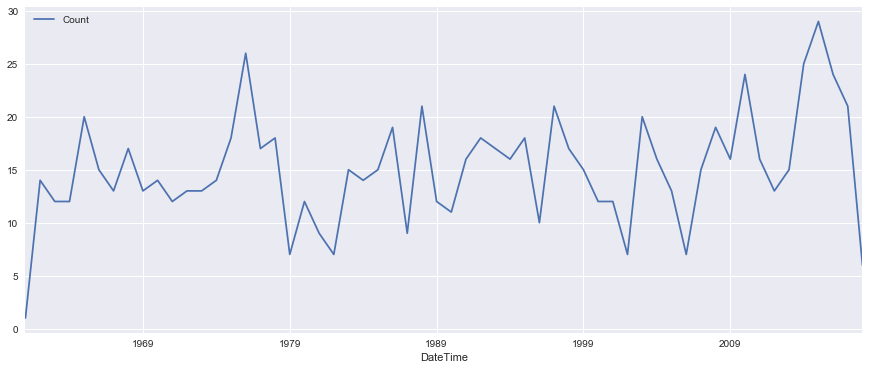

In [198]:
data.plot()

## Step 2: Stationarize the Series if required

In [199]:
# define Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput) 


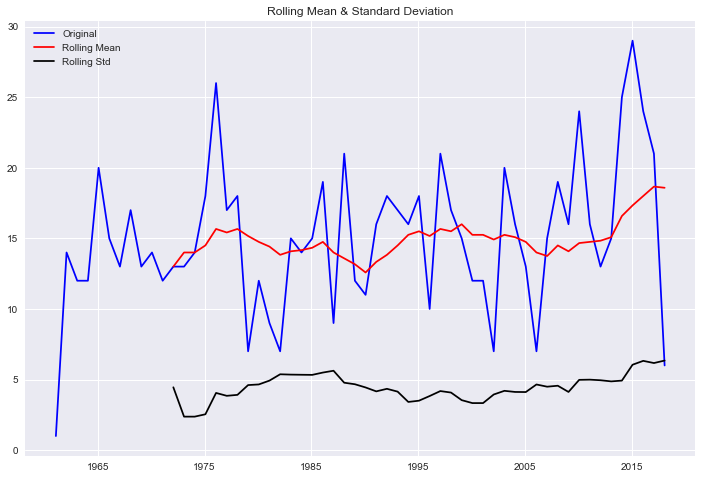

Results of Dickey-Fuller Test:
Test Statistic                -6.087235e+00
p-value                        1.057206e-07
#Lags Used                     0.000000e+00
Number of Observations Used    5.700000e+01
Critical Value (1%)           -3.550670e+00
Critical Value (5%)           -2.913766e+00
Critical Value (10%)          -2.594624e+00
dtype: float64


In [200]:
# perform test
test_stationarity(data.Count)

- The Test Statistic is lesser than the critical values. Form this I understand that the series is stationary.

## Step 3: Find Optimal Parameters - Plot ACF and PACF

## Step 4: Build ARIMA Model

In [201]:
import itertools

In [203]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [204]:
y = pd.Series(index = data.index, data = data.Count)

In [205]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:384.2839627123797
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1333.296221980059
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:308.5813627329955
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:293.8158091509696
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:224.20418180681676
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1316.1353592717496
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:429.2194468243833
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:329.7905447879079
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:292.345385803546
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1334.6276073313832
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:308.93567838172925
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:288.7379980540076
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:224.61191357569908
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1316.1033379255668
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:291.93816089994664
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1164.3904487759723
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:298.0147046347857
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:293.8405612900113
ARI

In [206]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8882      0.118     -7.550      0.000      -1.119      -0.658
ar.S.L12      -0.3760      0.180     -2.088      0.037      -0.729      -0.023
sigma2        38.1782     10.114      3.775      0.000      18.356      58.001


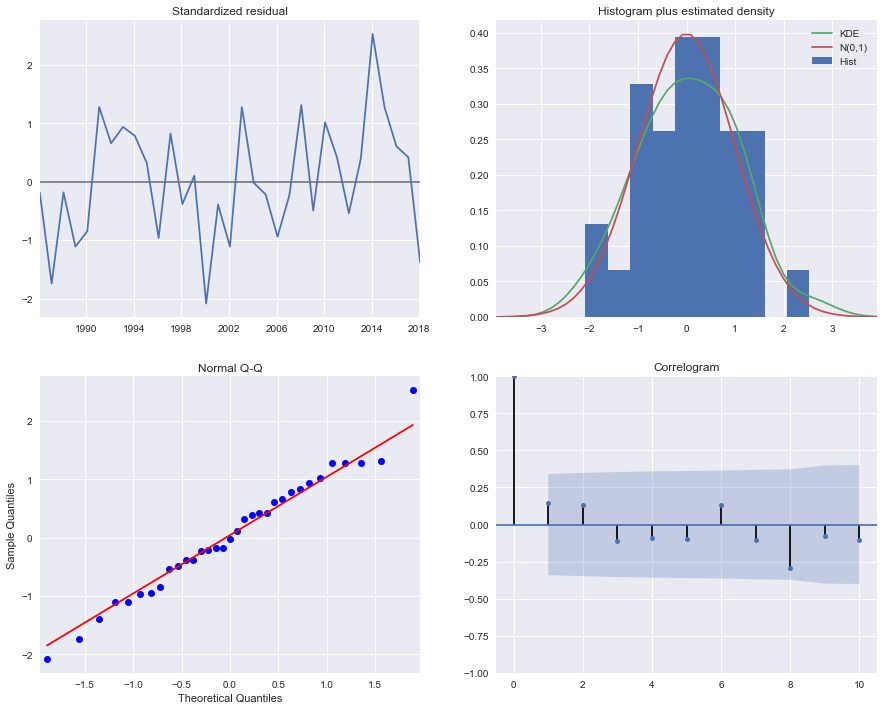

In [207]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Step 5: Make Predictions

In [208]:
y

DateTime
1961-01-31     1
1962-01-31    14
1963-01-31    12
1964-01-31    12
1965-01-31    20
1966-01-31    15
1967-01-31    13
1968-01-31    17
1969-01-31    13
1970-01-31    14
1971-01-31    12
1972-01-31    13
1973-01-31    13
1974-01-31    14
1975-01-31    18
1976-01-31    26
1977-01-31    17
1978-01-31    18
1979-01-31     7
1980-01-31    12
1981-01-31     9
1982-01-31     7
1983-01-31    15
1984-01-31    14
1985-01-31    15
1986-01-31    19
1987-01-31     9
1988-01-31    21
1989-01-31    12
1990-01-31    11
1991-01-31    16
1992-01-31    18
1993-01-31    17
1994-01-31    16
1995-01-31    18
1996-01-31    10
1997-01-31    21
1998-01-31    17
1999-01-31    15
2000-01-31    12
2001-01-31    12
2002-01-31     7
2003-01-31    20
2004-01-31    16
2005-01-31    13
2006-01-31     7
2007-01-31    15
2008-01-31    19
2009-01-31    16
2010-01-31    24
2011-01-31    16
2012-01-31    13
2013-01-31    15
2014-01-31    25
2015-01-31    29
2016-01-31    24
2017-01-31    21
2018-01-31     6
Freq:

In [209]:
x = pd.to_datetime('2010-01-31')
pred = results.get_prediction(start=x, dynamic=True)
pred_ci = pred.conf_int()

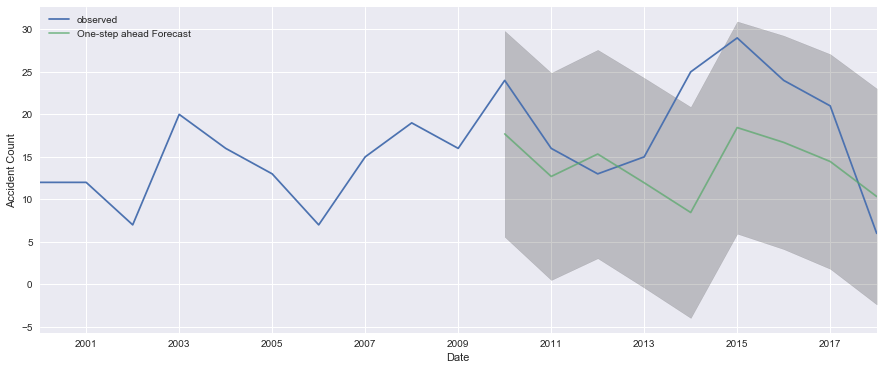

In [210]:
ax = y['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')
plt.legend()

plt.show()

In [214]:
y_forecasted = pred.predicted_mean
y_truth = y['2012-01-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 73.53


In [215]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2012-01-31'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

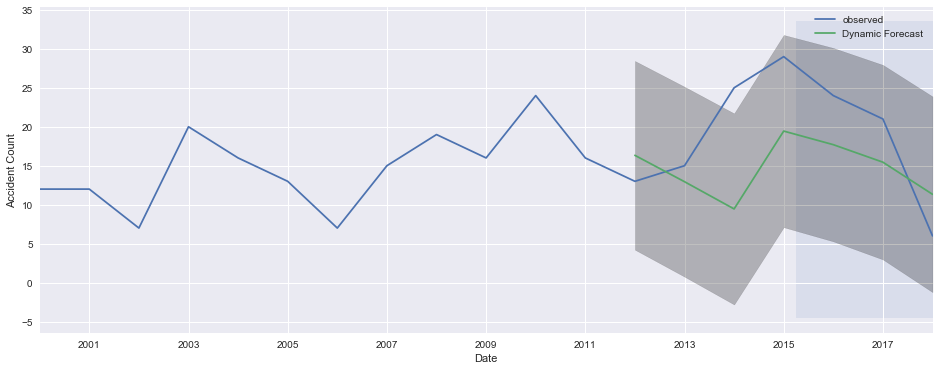

In [216]:
ax = y['2000':].plot(label='observed', figsize=(16, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-04-30'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Accident Count')

plt.legend()
plt.show()

In [217]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['2012-04-30':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 72.67


In [218]:
# Get forecast 10 steps ahead in future
pred_uc = results.get_forecast(steps=20)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

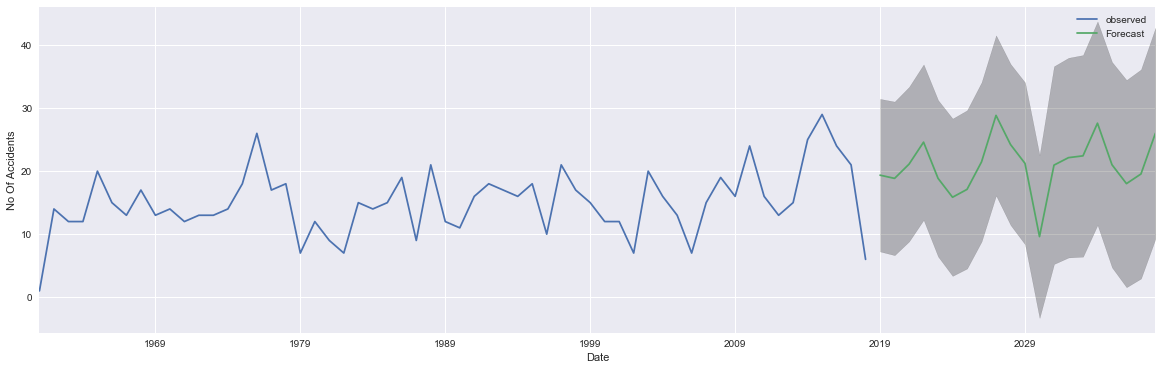

In [219]:
ax = y.plot(label='observed', figsize=(20, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('No Of Accidents')

plt.legend()
plt.show()